In [1]:
#libreria para manejo de NDARRAY
import numpy as np;
import scipy as sp
#libreria para graficar
#tipo matlab: pyplot
#objetual: figure, axes
import matplotlib.pyplot as plt
from csv import reader as reader_csv;
import scipy.signal as signal;
import spacy
import scipy.io as sio
import scipy.stats as stats
from sympy import symbols
import os
import sympy as sym
import pandas as pd
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import mannwhitneyu


In [2]:

ruta_carpeta = './control'

# Obtener la lista de archivos en la carpeta
lista_archivos = os.listdir(ruta_carpeta)

# Crear una matriz vacía para almacenar los datos
datos_matriz = [] # num_columnas es el número de columnas en los datos

# Iterar a través de cada archivo y agregar los datos a la matriz
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_matriz.append(data)

ruta_carpeta = './parkinson'
lista_archivos = os.listdir(ruta_carpeta)
datos_parkinson=[]
for archivo in lista_archivos:
    # Verificar que el archivo sea de tipo .mat
    if archivo.endswith('.mat'):
        # Cargar los datos del archivo
        mat_contents = sio.loadmat(os.path.join(ruta_carpeta, archivo))
        data = mat_contents['data']
        senal_continua = np.reshape(data,(data.shape[0],data.shape[1]*data.shape[2]),order='F')
        # Agregar los datos a la matriz
        datos_parkinson.append(data)
print("Todo cargado")

Todo cargado


In [3]:
def ecu_spectraldensity(xn,nl,N):
    sums_sk=[]
    w_n=0.42-0.5*np.cos((2*np.pi*nl)/(N-1))
    xn=w_n*xn
    for k in nl:
        s_k=np.abs(np.sum(xn*np.exp((-1j*2*np.pi*k*nl)/N)))**2
        sums_sk.append(s_k)
    return np.array(sums_sk)/N

In [4]:
def spectraldensity(xn,epoca=119,paciente=0):
    xn=xn[paciente]
    xn=xn[:,:,epoca]
    sums_k_list=[]
    for canal in xn:
        N=len(canal)
        nl=np.arange(N)
        s_k=ecu_spectraldensity(canal,nl,N)
        sums_k_list.append(s_k)
    return sums_k_list

In [5]:
x=spectraldensity(datos_matriz,119,0)


In [6]:
np.shape(x)
x[0]

array([ 5.53924612, 18.28113981, 93.91374095, ..., 44.65120132,
       93.91374095, 18.28113981])

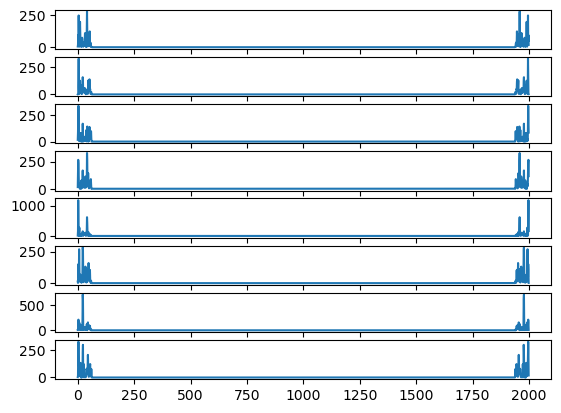

In [7]:
for i in range(len(x)):
    plt.subplot(8,1,i+1)
    plt.plot(x[i])
plt.show()

# 2 
Crear una función que reciba una señal EEG de múltiples épocas, un canal, y devuelva la sumatoria de densidad espectral de potencia, para el rango de frecuencia de 13 a 30 Hz, del promedio de la densidad espectral de potencia de las diferentes épocas de la señal de análisis

In [69]:
def sum_spectraldensity2(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    norm=len(data[paciente][canal,:,:])/fs
    fini2,ffin2=int(fini*norm),int(ffin*norm)
    data=data[paciente][canal,fini2:ffin2+1,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.linspace(fini2,ffin2,num=ffin2-fini2+1)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(fini,ffin,num=N)
    return s_k,frecuencia

In [63]:
def sum_spectraldensity(data,canal=0,paciente=0,fs=1000,fini=13,ffin=30):
    data=data[paciente][canal,:,:]
    puntos=[]
    for punto in data:
        p=np.mean(punto)
        puntos.append(p)
    z=np.array(puntos)
    N=len(z)
    nl=np.arange(N)
    s_k=ecu_spectraldensity(z,nl,N)
    frecuencia=np.linspace(0,fs,num=N)
    return s_k,frecuencia

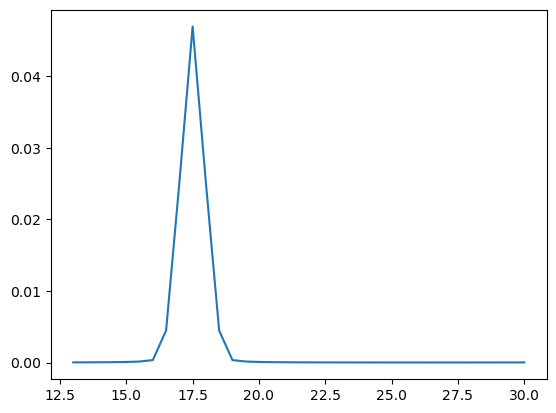

In [70]:
s_k,frecuencia=sum_spectraldensity2(datos_matriz,0,0)
plt.plot(frecuencia,s_k)

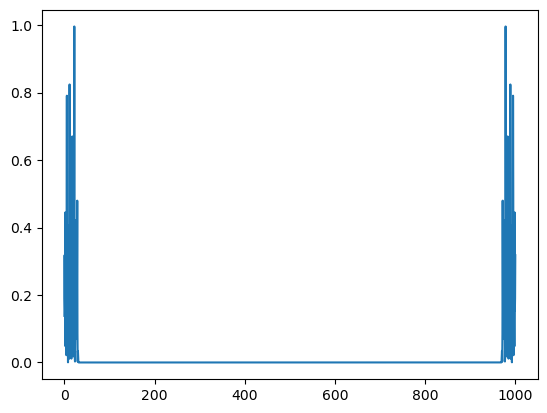

In [64]:
x,f=sum_spectraldensity(datos_matriz,0,0)
plt.plot(f,x)


In [15]:
def spectralrange(x,f,ini=13,end=30):
    bf=np.where((f>=13) &(f<=30))
    f=f[bf]
    x=x[bf]
    return f,x

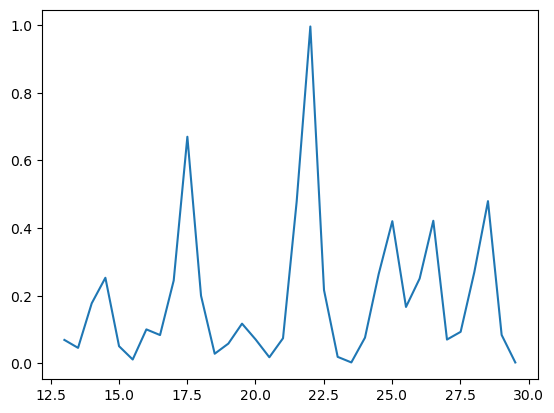

In [65]:
f,x=spectralrange(x,f,13,30)
plt.plot(f,x)

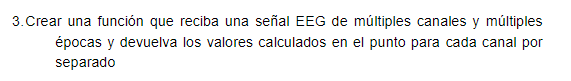

In [17]:
def PSD(data,paciente=0):
    sums_k_list=[]
    canales=np.arange(len(data[paciente][:,0,0]))
    for canal in canales:
        s_k,f=sum_spectraldensity(data,canal,paciente)
        f,x=spectralrange(s_k,f)
        s_k=np.sum(x)
        sums_k_list.append(s_k)
    return sums_k_list

In [19]:
X=PSD(datos_matriz)

In [20]:
print(X)

[6.588136262156796, 7.170274084597011, 8.488089358209756, 6.342503451805725, 6.311502654693775, 8.79407395065854, 7.26157308045821, 11.369824100507422]


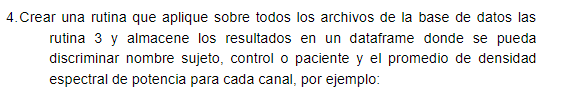

In [66]:
datosprompaciente=[]
r=np.arange(len(datos_matriz))
for i in r:
    promcanales=["Control"]
    x=PSD(datos_matriz,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente.append(promcanales)

datosprompaciente_p=[]
r=np.arange(len(datos_parkinson))
for i in r:
    promcanales=["Parkinson"]
    x=PSD(datos_parkinson,i)
    for canal in x:
        promcanales.append(canal)
    datosprompaciente_p.append(promcanales)

In [67]:
names = ["Estado",'PSD_C3', 'PSD_C1', 'PSD_CZ', 'PSD_C2', 'PSD_C4', 'PSD_O1', 'PSD_OZ', 'PSD_O2'] #Los nombres de las columnas
df=pd.DataFrame(columns=names) #Se crea el data frame
con=1 
for paciente in datosprompaciente: #Se inspecciona cada paciente, en este caso pandas toma las listas así que solo se coloca paciente (lista con primedio de cada canal) y el contador para identificar el paciente
    df.loc[con]=paciente
    con+=1
for paciente in datosprompaciente_p:
    df.loc[con]=paciente
    con+=1
df.index.name="Sujeto"
df

,Estado,PSD_C3,PSD_C1,PSD_CZ,PSD_C2,PSD_C4,PSD_O1,PSD_OZ,PSD_O2
Sujeto,,,,,,,,,
1,Control,6.588136,7.170274,8.488089,6.342503,6.311503,8.794074,7.261573,11.369824
2,Control,6.937180,4.682711,2.739435,2.267806,4.730358,13.290693,11.449452,12.883728
3,Control,4.018534,3.599051,5.457592,2.222556,5.556907,2.553184,2.944823,4.609807
4,Control,9.762080,6.623699,9.884979,11.724950,14.610523,22.633438,15.156428,12.204539
5,Control,5.309109,6.728339,8.453612,8.823974,8.370769,10.319439,9.530214,9.589701
6,Control,6.184479,5.465086,4.825497,3.054241,3.661056,4.980654,5.412684,6.552773
7,Control,4.139802,2.935076,3.841803,4.263166,5.032301,7.541838,6.499612,9.207845
8,Control,3.629768,2.767345,2.806591,2.857862,5.790350,6.864858,6.927915,9.292365
9,Control,1.926986,2.042166,2.071883,1.542974,1.392093,12.023476,8.962724,8.070981


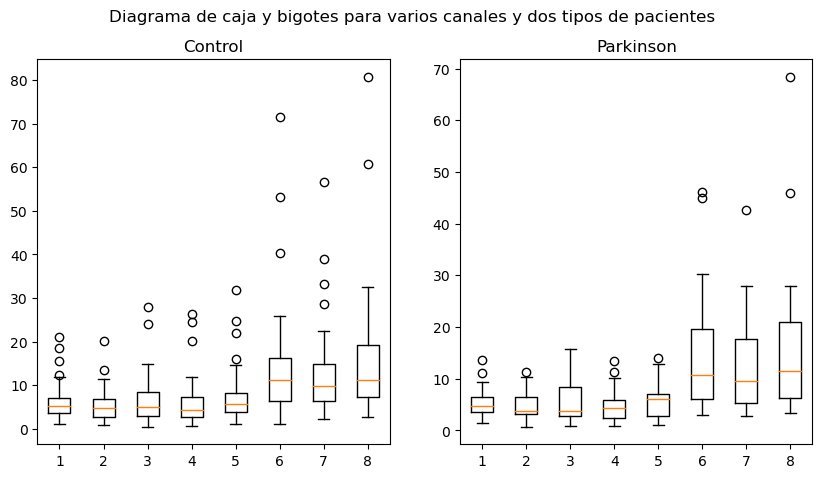

In [68]:
# Crear una lista de dataframes, uno por cada estado
dataframes = [df[df['Estado']=='Control'], df[df['Estado']=='Parkinson']]

# Crear una lista de nombres para las etiquetas del gráfico
labels = ['Control', 'Parkinson']

# Crear una figura y dos subplots (uno por cada estado)
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Para cada estado y subplot, hacer un diagrama de caja y bigotes para cada canal
for i, df_estado in enumerate(dataframes):
    axs[i].boxplot([df_estado['PSD_C3'], df_estado['PSD_C1'], df_estado['PSD_CZ'], df_estado['PSD_C2'], df_estado['PSD_C4'], df_estado['PSD_O1'], df_estado['PSD_OZ'], df_estado['PSD_O2']])
    axs[i].set_title(labels[i])
fig.suptitle('Diagrama de caja y bigotes para varios canales y dos tipos de pacientes')
plt.show()

In [24]:
def check_normality(data):
    '''Check if the distribution is normal.'''
    
    # --- >>> START stats <<< ---
    # Graphical test: if the data lie on a line, they are pretty much
    # normally distributed
    _ = stats.probplot(data, plot=plt)
    plt.show()

    pVals = pd.Series('p-value')
    # The scipy normaltest is based on D-Agostino and Pearsons test that
    # combines skew and kurtosis to produce an omnibus test of normality.
    _, pVals['Omnibus']    = stats.normaltest(data)

    # Shapiro-Wilk test
    _, pVals['Shapiro-Wilk']    = stats.shapiro(data)
    
    print('--------------------------------')
    print('p-values for all {0} data points:'.format(len(data)))
    print(pVals)
    print('--------------------------------')
    
    if pVals['Omnibus'] > 0.05:
        print('Data are normally distributed')
    elif pVals['Shapiro-Wilk'] > 0.05:
        print('Data are normally distributed')
    else:
        print("Data arent normally distribuited")
    # --- >>> STOP stats <<< ---
    print('--------------------------------')
    
    return [pVals['Shapiro-Wilk'],pVals['Omnibus']]

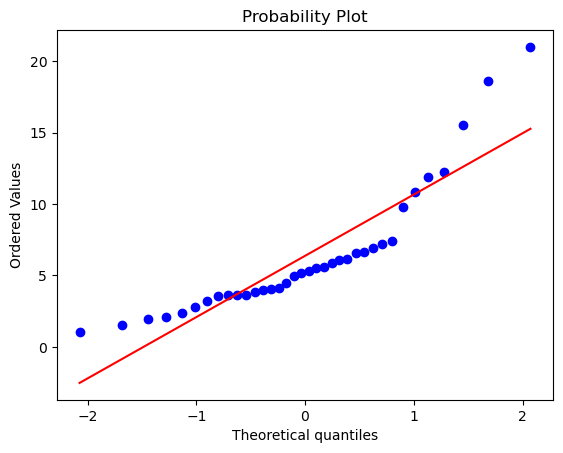

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000059
Shapiro-Wilk    0.000043
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


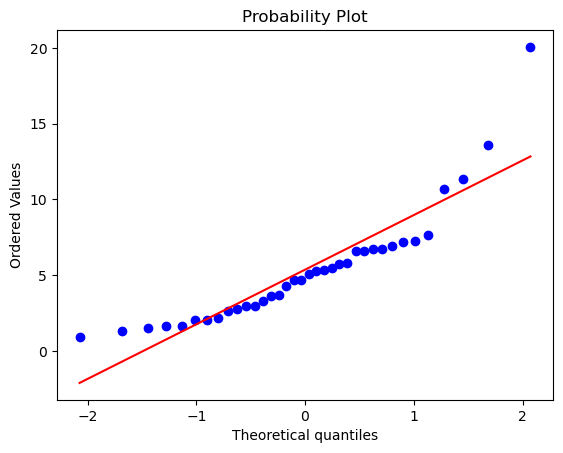

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000002
Shapiro-Wilk    0.000079
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


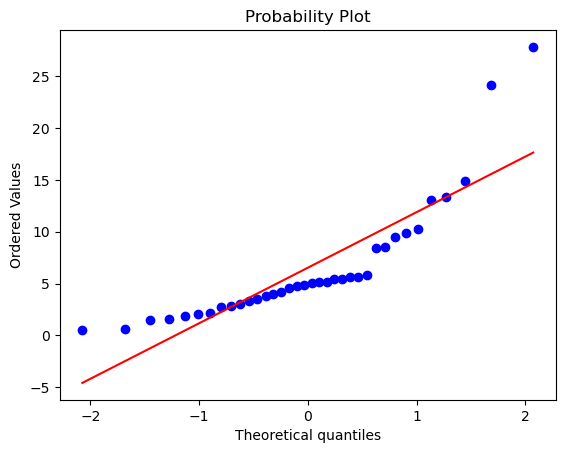

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000001
Shapiro-Wilk    0.000003
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


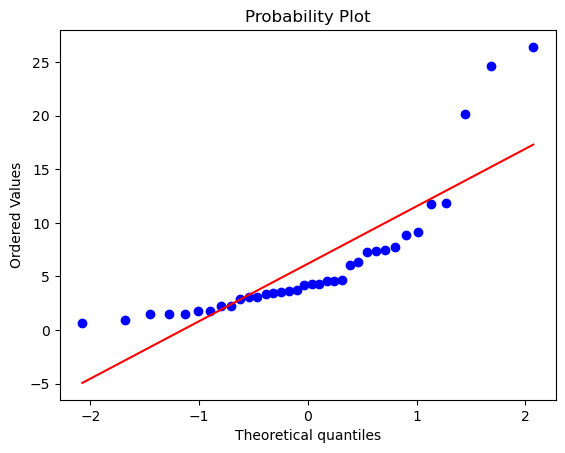

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000001
Shapiro-Wilk    0.000001
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


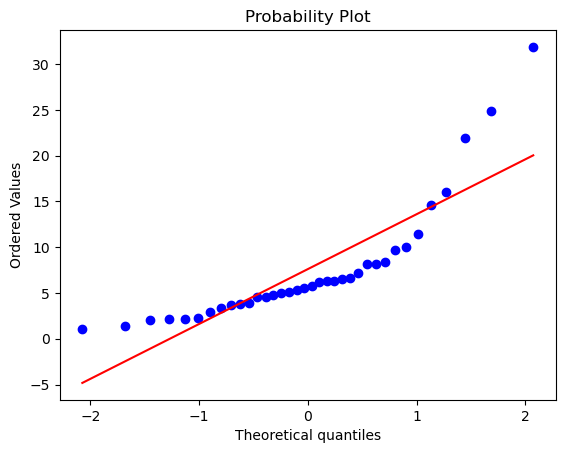

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus         0.000001
Shapiro-Wilk    0.000002
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


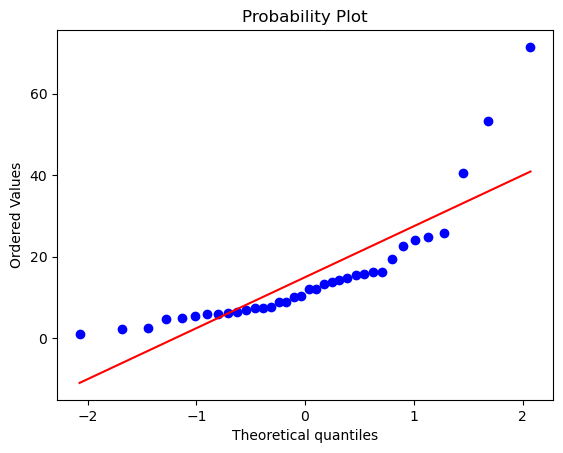

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus              0.0
Shapiro-Wilk    0.000001
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


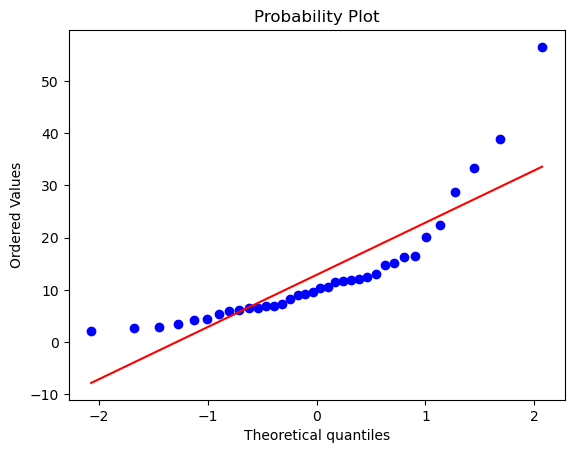

--------------------------------
p-values for all 36 data points:
0                p-value
Omnibus              0.0
Shapiro-Wilk    0.000003
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


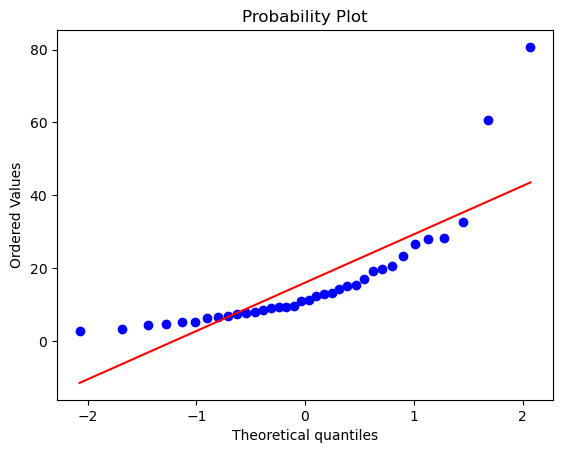

--------------------------------
p-values for all 36 data points:
0               p-value
Omnibus             0.0
Shapiro-Wilk        0.0
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


In [25]:
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes control
    c=df.loc[1:36,i]
    x=check_normality(c)

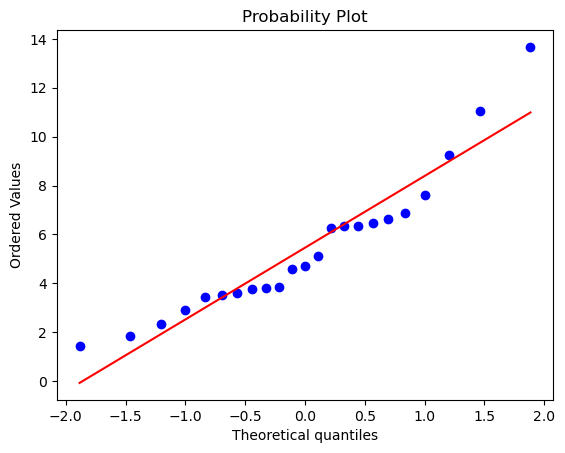

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.018338
Shapiro-Wilk    0.041937
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


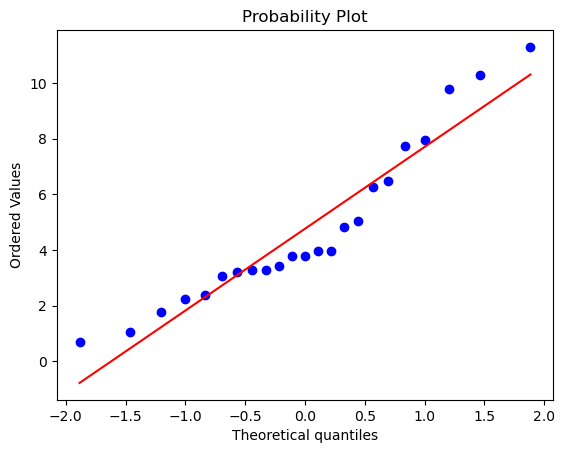

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.185987
Shapiro-Wilk    0.043972
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


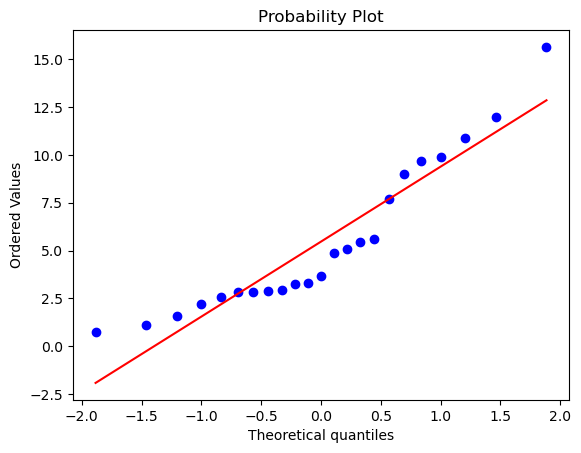

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.089332
Shapiro-Wilk    0.013357
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


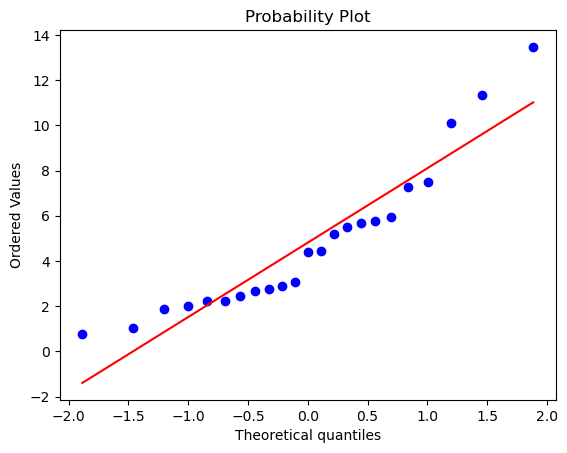

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.035403
Shapiro-Wilk    0.014597
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


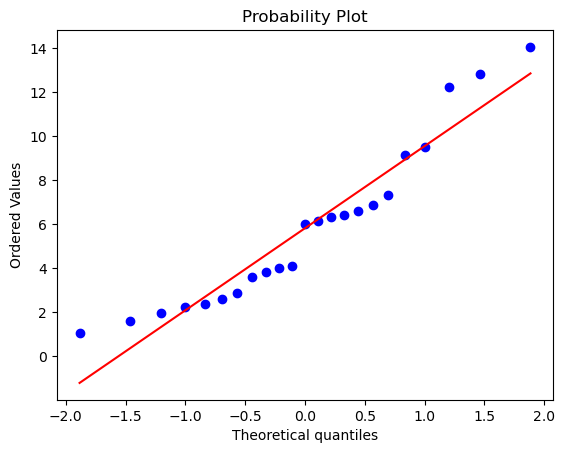

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.220734
Shapiro-Wilk    0.049105
dtype: object
--------------------------------
Data are normally distributed
--------------------------------


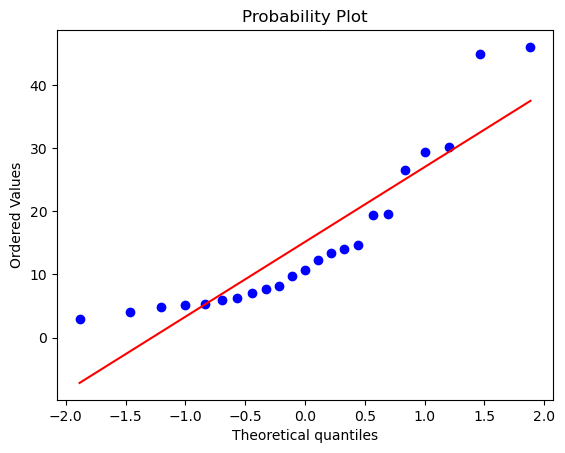

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.010307
Shapiro-Wilk    0.000835
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


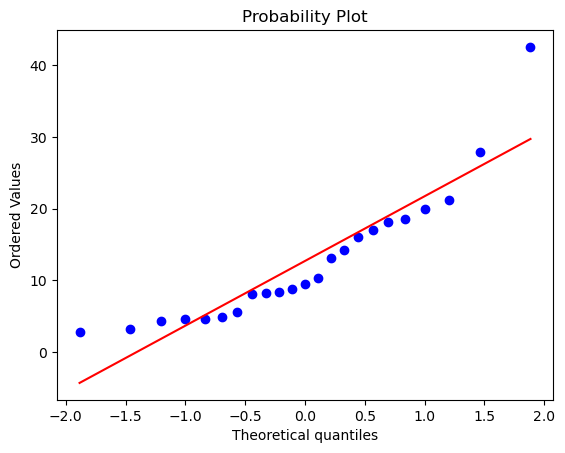

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.000556
Shapiro-Wilk    0.003042
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


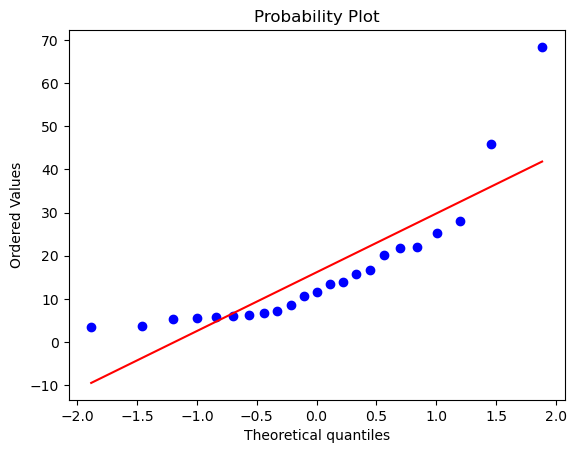

--------------------------------
p-values for all 23 data points:
0                p-value
Omnibus         0.000005
Shapiro-Wilk     0.00006
dtype: object
--------------------------------
Data arent normally distribuited
--------------------------------


In [26]:
for i in names[1:]: #Se aplica la prueba de normalidad a cada canal de los pacientes Parkinson
    c=df.loc[37:59,i]
    x=check_normality(c)

In [27]:
for i in names[1:]:
    dataframes=[df[df['Estado']=='Control'] & df[i], df[df['Estado']=='Parkinson'] & df[i]]
    stat, p = mannwhitneyu(dataframes[0],dataframes[1])
con=0
for i in p: #solo imprimo los resultados de cada canal despues de pasar por la prueba no parametrica
    print('Statistics=%.3f, p=%.3f for channel %s' % (stat[con], i,names[con]))
    con+=1
    #interpret
    alpha = 0.05
    if i > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

TypeError: unsupported operand type(s) for &: 'str' and 'bool'

In [ ]:
#VERIFICANDO HOMOSEDASTICIDAD
con=0
for i in names:
  c=df.loc[:,i]
  p=dfp.loc[:,i] 
  p_valor = levene(c, p).pvalue
  print("Canal %s p=%.3f "% (names[con],p_valor))
  con+=1
  if p_valor > 0.05:
    print("Los datos son homocedásticos.")
  else:
    print("Los datos no son homocedásticos.")